In [2]:
import os
import time
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from medmnist import OrganAMNIST
from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio
from IPython import display
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from matplotlib import rcParams
plt.rcParams['font.family'] = 'STIXGeneral'

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

os.makedirs("./data", exist_ok=True)
os.makedirs(os.path.dirname("./models/model.pth"), exist_ok=True)
os.makedirs("./results", exist_ok=True)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2 * x - 1.0),      # Normalizes tensor to [-1, 1]
    #transforms.Lambda(lambda x: x.float()),
])

#The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity.
#We use bounding-box annotations of 11 body organs from another study to obtain the organ labels.
#Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window.
#We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes).
#The images are resized into 1×28×28 to perform multi-class classification of 11 body organs.
#115 and 16 CT scans from the source training set are used as training and validation set, respectively.
#The 70 CT scans from the source test set are treated as the test set.

train_data = OrganAMNIST(root="./data", split="train", download=True, transform=transform)
val_data   = OrganAMNIST(root="./data", split="val",   download=True, transform=transform)
test_data  = OrganAMNIST(root="./data", split="test",  download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True, persistent_workers=True if 2 > 0 else False)
val_loader   = DataLoader(val_data,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True if 2 > 0 else False)
test_loader  = DataLoader(test_data,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True if 2 > 0 else False)

print(f"Dataset sizes  • Train: {len(train_data)}  Val: {len(val_data)}  Test: {len(test_data)}")

# first 16 images from test dataset [16,1,28,28]
viz_batch_clean = torch.stack([test_data[i][0] for i in list(range(min(16, len(test_data))))]).to(DEVICE)
viz_batch_noisy = (viz_batch_clean + 0.3 * torch.randn_like(viz_batch_clean)).clamp(-1, 1) # noise-level(sigma) = 0.3

Using device: cuda
Dataset sizes  • Train: 34561  Val: 6491  Test: 17778


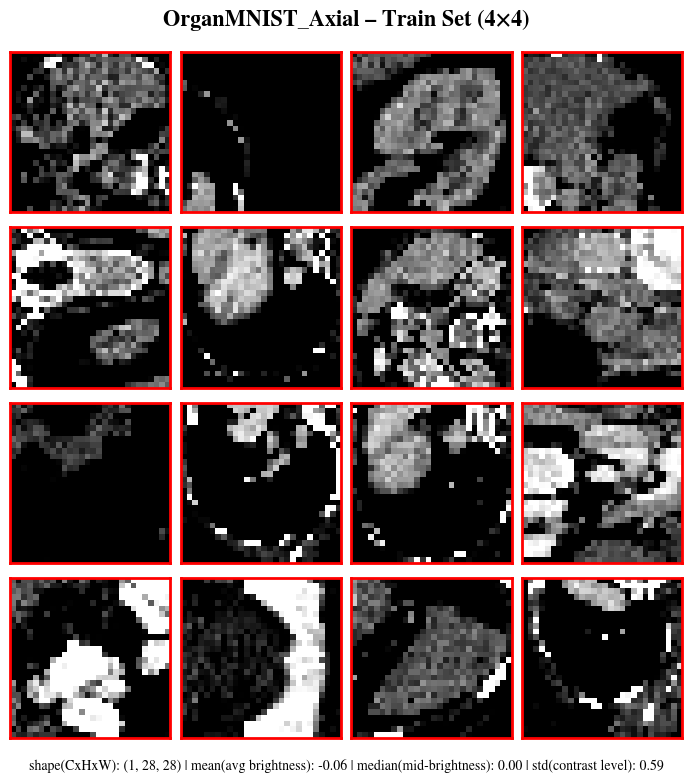

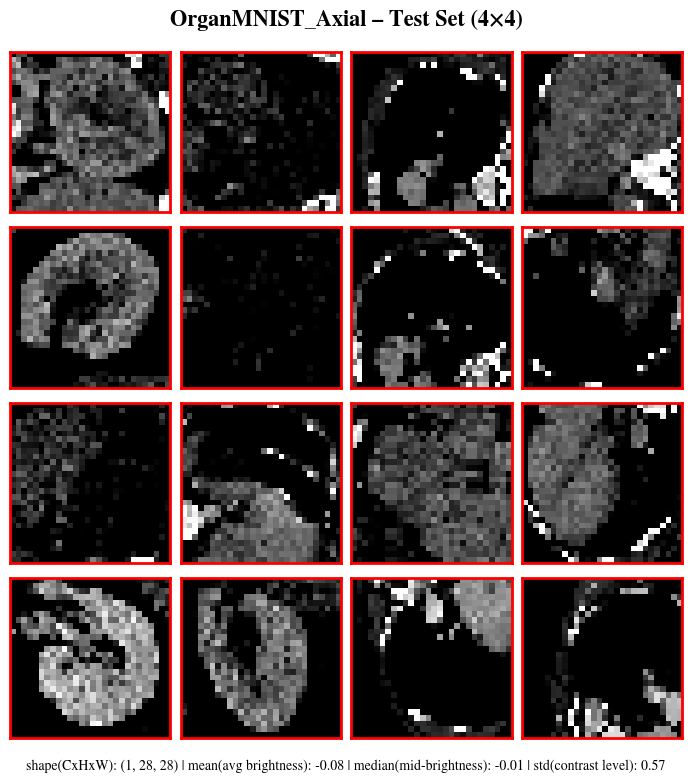

In [5]:
def show_grid(imgs, tag, full_stats_imgs):
    imgs = imgs.squeeze(1) if imgs.ndim == 4 else imgs
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    fig.suptitle(f"OrganMNIST_Axial – {tag} Set (4×4)", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.04, 1, 0.50])

    for ax, img in zip(axs.ravel(), imgs[:16]):
        ax.imshow(img, cmap='gray', vmin=0, vmax=1)
        ax.set_xticks([]); ax.set_yticks([])
        for spine in ax.spines.values(): spine.set(color='red', linewidth=2.0)

    full_flat = full_stats_imgs.squeeze(1).flatten()
    stats = f"shape(CxHxW): {tuple(full_stats_imgs.shape[1:])} | mean(avg brightness): {full_flat.mean():.2f} | median(mid-brightness): {full_flat.median():.2f} | std(contrast level): {full_flat.std():.2f}"
    fig.text(0.5, 0.03, stats, ha='center', fontsize=10)
    plt.tight_layout(rect=[0, 0.05, 1, 0.99])
    plt.show()


train_imgs = torch.stack([train_data[i][0] for i in range(len(train_data))])
test_imgs  = torch.stack([test_data[i][0]  for i in range(len(test_data))])

show_grid(train_imgs[:16], tag='Train', full_stats_imgs=train_imgs)
show_grid(test_imgs[:16],  tag='Test',  full_stats_imgs=test_imgs)

In [6]:
# ---Variance Preserving Stochastic Differential Equation---
class VPSDE:

    def __init__(self, n_steps=1000, device="cpu"):
        """
        n_steps (int): The number of diffusion steps (T). Default: 1000.
        Calculates:
        discrete_betas (torch.Tensor): Discrete noise variances $\beta_t$ for $t=1,...,T$. Shape: [n_steps].
        alphas (torch.Tensor): $1 - \beta_t$. Shape: [n_steps].
        alphas_cumprod (torch.Tensor): Cumulative product $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$. Shape: [n_steps].
        sqrt_alphas_cumprod (torch.Tensor): $\sqrt{\bar{\alpha}_t}$. Shape: [n_steps].
        sqrt_one_minus_alphas_cumprod (torch.Tensor): $\sqrt{1 - \bar{\alpha}_t}$. Shape: [n_steps].
        """

        self.n_steps = n_steps
        self.device = device

        # --- Cosine Schedule Calculation ---
        # Small offset to prevent beta_t from being zero at t=0

        s = 0.008

        # Time steps from 0 to T (inclusive for alpha_bar calculation)

        steps = torch.linspace(0, n_steps, n_steps + 1, device=device)

        # alpha_bar_t = cos^2 ( (pi/2) * (t/T + s) / (1 + s) )

        f_t = torch.cos(((steps / n_steps) + s) / (1 + s) * math.pi / 2) ** 2
        self.alphas_cumprod = f_t / f_t[0] # Normalized cumulative product \bar{\alpha}_t

        # beta_t = 1 - (alpha_bar_t / alpha_bar_{t-1})
        # clamped to prevent numerical issues near t=T

        self.discrete_betas = (1 - (self.alphas_cumprod[1:] / self.alphas_cumprod[:-1])).clamp(0.0001, 0.9999)
        self.alphas_cumprod = self.alphas_cumprod[1:] # Shape: [n_steps]
        self.alphas = 1. - self.discrete_betas # \alpha_t = 1 - \beta_t. Shape: [n_steps]

        # sqr roots needed for sampling q(x_t | x_0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)             # sqrt(\bar{\alpha}_t). Shape: [n_steps]
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod) # sqrt(1 - \bar{\alpha}_t). Shape: [n_steps]

    def _to_index(self, t):
        """
        Converts continuous time `t` (float tensor or scalar between 0.0 and 1.0)
        to discrete time steps (indices from 0 to n_steps-1).

        t (torch.Tensor or float): Continuous time step(s), normalized to [0, 1].
                                       Shape: scalar or [B].

        torch.Tensor: Corresponding discrete indices (long tensor). Shape matches input `t`.
                          Mapping: index = floor(t * (N-1)) clamped to [0, N-1].
        """
        t_on_device = t.to(self.discrete_betas.device) if isinstance(t, torch.Tensor) else torch.tensor(t, device=self.discrete_betas.device)

        # map t from [0, 1] to idx [0, n_steps-1]
        index = (t_on_device * (self.n_steps - 1)).long().clamp(min=0, max=self.n_steps - 1)
        return index

    def alpha(self, t):
        """
        Returns $\sqrt{\bar{\alpha}_t}$ for given time `t`.

        t (torch.Tensor or float): Continuous time step(s) [0, 1]. Shape: scalar or [B].

        torch.Tensor: $\sqrt{\bar{\alpha}_t}$ values. Shape matches input `t`.
        """
        idx = self._to_index(t)
        idx = idx.clamp(0, self.sqrt_alphas_cumprod.shape[0] - 1)
        return self.sqrt_alphas_cumprod[idx]


    def sigma(self, t):
        """
        Returns $\sqrt{1 - \bar{\alpha}_t}$ for given time `t`.

        t (torch.Tensor or float): Continuous time step(s) [0, 1]. Shape: scalar or [B].

        torch.Tensor: $\sqrt{1 - \bar{\alpha}_t}$ values. Shape matches input `t`.
        """
        idx = self._to_index(t)
        idx = idx.clamp(0, self.sqrt_one_minus_alphas_cumprod.shape[0] - 1)
        return self.sqrt_one_minus_alphas_cumprod[idx]


    def marginal_prob(self, x0, t):
        """
        Calculates the mean and standard deviation of the marginal distribution $q(x_t | x_0)$.
        $q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) \mathbf{I})$

        x0 (torch.Tensor): The initial clean data (e.g., image batch).
                               Shape: [B, C, H, W].
        t (torch.Tensor or float): Continuous time step(s) [0, 1]. Shape: scalar or [B].

        tuple(torch.Tensor, torch.Tensor):
            - mean (torch.Tensor): Mean of the distribution $\sqrt{\bar{\alpha}_t} x_0$.
                                       Shape: [B, C, H, W].
            - std (torch.Tensor): Standard deviation $\sqrt{1 - \bar{\alpha}_t}$.
                                      Shape: [B] (broadcastable for sampling).
        """

        t_on_device = t.to(x0.device) if isinstance(t, torch.Tensor) else torch.tensor(t, device=x0.device)

        # mean: \sqrt{\bar{\alpha}_t} * x0
        mean = self.alpha(t_on_device).view(-1, 1, 1, 1) * x0 # Reshape alpha to [B, 1, 1, 1] for broadcasting

        # std: \sqrt{1 - \bar{\alpha}_t}
        std = self.sigma(t_on_device) # Shape [B]

        return mean, std


    def forward(self, x0, t):
        """
        Samples from the forward process distribution $q(x_t | x_0)$ to get a noisy image $x_t$.
        $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} z$, where $z \sim \mathcal{N}(0, \mathbf{I})$

        x0 (torch.Tensor): The initial clean data (e.g., image batch).
                               Shape: [B, C, H, W].
        t (torch.Tensor or float): Continuous time step(s) [0, 1]. Shape: scalar or [B].

        tuple(torch.Tensor, torch.Tensor):
            - xt (torch.Tensor): The noisy data at time `t`. Shape: [B, C, H, W].
            - z (torch.Tensor): The standard Gaussian noise used. Shape: [B, C, H, W].
        """

        t_on_device = t.to(x0.device) if isinstance(t, torch.Tensor) else torch.tensor(t, device=x0.device)
        mean, std = self.marginal_prob(x0, t_on_device)

        # standard Gaussian noise z ~ N(0, I)
        z = torch.randn_like(x0)

        # noisy sample xt = mean + std * z
        # reshape std to [B, 1, 1, 1] for broadcasting
        xt = mean + std.view(-1, 1, 1, 1) * z

        return xt, z

sde = VPSDE(n_steps=1000, device=DEVICE)

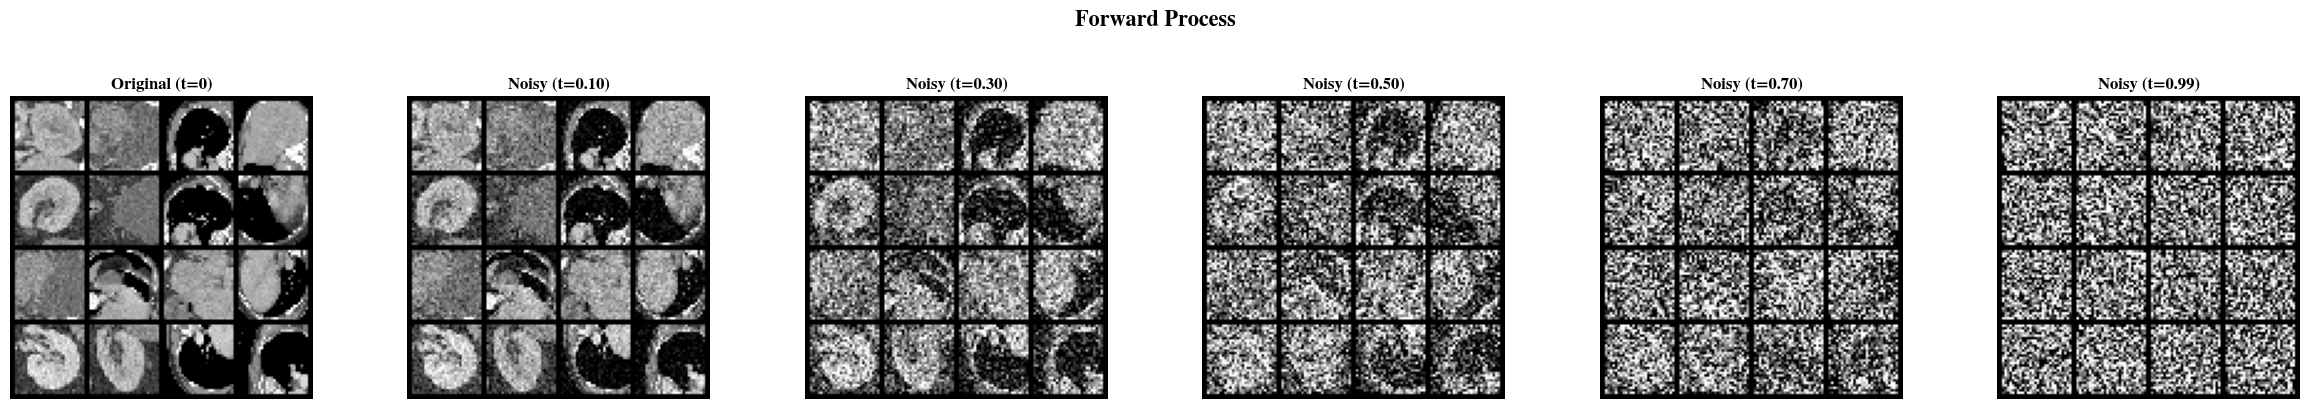

In [7]:
def visualize_sde_batch_forward(sde, image_batch, time_points, device):
    image_batch = image_batch.to(device)
    num_images = image_batch.size(0)
    grid_rows = int(math.sqrt(num_images))
    times = [0.0] + time_points
    fig, axes = plt.subplots(1, len(times), figsize=(len(times) * 4, 4.5), squeeze=False)
    axes = axes[0]

    fig.suptitle("Forward Process", fontsize=16, fontweight='bold')
    plt.subplots_adjust(top=0.80)

    with torch.no_grad():
        for i, t in enumerate(times):
            if t == 0.0:
                batch = image_batch
                title = "Original (t=0)"
            else:
                t_tensor = torch.full((num_images,), t, device=device)
                batch, _ = sde.forward(image_batch, t_tensor)
                title = f"Noisy (t={t:.2f})"

            disp = (batch.detach().cpu().clamp(-1, 1) + 1) / 2
            grid = make_grid(disp, nrow=grid_rows, padding=2)

            axes[i].imshow(grid.permute(1, 2, 0).numpy())
            axes[i].set_title(title, fontsize=12, fontweight='bold')
            axes[i].axis('off')
            for spine in axes[i].spines.values():
                spine.set_visible(True)
                spine.set_color('#444')
                spine.set_linewidth(1.5)

    plt.tight_layout(rect=[0, 0.08, 1, 0.9])
    plt.show()

time_points = [0.1, 0.3, 0.5, 0.7, 0.99]
visualize_sde_batch_forward(sde, viz_batch_clean, time_points, DEVICE)

In [18]:
# --- Neural Network ---

class SelfAttention(nn.Module):
    """
    x (torch.Tensor): Input feature map. Shape: [B, C, H, W]

    torch.Tensor: Output feature map after applying attention and adding residual.
                  Shape: [B, C, H, W] (same as input)
    """
    def __init__(self, channels, num_heads=4):
        super().__init__()
        assert channels % num_heads == 0, f"Channels ({channels}) must be divisible by num_heads ({num_heads})"
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        self.scale = self.head_dim ** -0.5 # 1 / sqrt(d_k)
        self.norm = nn.GroupNorm(num_groups=max(1, channels // 32), num_channels=channels)

        # Linear projection to Query, Key, Value matrices using 1x1 Convolution
        # Input: [B, C, H, W] -> Output: [B, 3*C, H, W]
        self.to_qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)

        # Final linear projection (1x1 Conv) after attention
        # Input: [B, C, H, W] -> Output: [B, C, H, W]
        self.to_out = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        # Input shape: x [B, C, H, W]
        B, C, H, W = x.shape
        res = x
        x = self.norm(x)

        # Project to Q, K, V and split into 3 tensors
        # qkv shape: [B, 3*C, H, W]
        # q, k, v shapes: each [B, C, H, W]
        qkv = self.to_qkv(x).chunk(3, dim=1)

        # reshaped from [B, C, H, W] to [B, num_heads, head_dim, H*W]
        # permuted to [B, num_heads, H*W, head_dim] for matrix multiplication
        # 'b n (hw) d' where b=B, n=num_heads, hw=H*W, d=head_dim
        q, k, v = map(
            lambda t: t.view(B, self.num_heads, self.head_dim, H * W).permute(0, 1, 3, 2),
            qkv
        )

        # Attention(Q, K, V) = softmax( (Q @ K.T) / sqrt(d_k) ) @ V
        # Q @ K.T: MatMul ([B, n, hw, d], [B, n, d, hw]) -> dots [B, n, hw, hw]
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # attn shape: [B, n, hw, hw]
        attn = dots.softmax(dim=-1)

        # MatMul ([B, n, hw, hw], [B, n, hw, d]) -> out [B, n, hw, d]
        out = torch.matmul(attn, v)

        # Permute: [B, n, hw, d] -> [B, n, d, hw]
        # Reshape: [B, n, d, hw] -> [B, C, H, W] (since C = n * d)
        out = out.permute(0, 1, 3, 2).reshape(B, C, H, W)
        out = self.to_out(out)

        return out + res

class Unet(nn.Module):
    """
    predict noise `z` given a noisy input `xt` and time `t`.

    x (torch.Tensor): Noisy input image batch. Shape: [B, InC, H, W]
    t (torch.Tensor): Time step tensor. Shape: [B] (continuous time [0, 1])

    torch.Tensor: Predicted noise. Shape: [B, OutC, H, W]
    """
    def __init__(self, in_channels=1, out_channels=1, hidden_dim=48, num_heads=4):
        super().__init__()
        self.hidden_dim = hidden_dim

        # --- Time Embedding ---
        # time `t` (scalar) into a feature vector using MLPs.
        # Input `t`: [B, 1] (after view(-1, 1))
        # Output `t_emb`: [B, hidden_dim]

        self.time_mlp = nn.Sequential(
            # Linear layer: [B, 1] -> [B, hidden_dim * 4]
            nn.Linear(1, hidden_dim * 4),
            # SiLU (Swish) activation: f(x) = x * sigmoid(x)
            nn.SiLU(),
            # Linear layer: [B, hidden_dim * 4] -> [B, hidden_dim]
            nn.Linear(hidden_dim * 4, hidden_dim)
        )

        # --- Encoder Path (Downsampling) ---
        # Input x: [B, in_channels, H, W]
        # Output x1: [B, hidden_dim, H, W]
        # Kernel=3, Padding=1
        self.conv_in = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)

        # Downsampling block 1
        # Input x1: [B, hidden_dim, H, W]
        # Conv2d: Stride=2 halves H and W. Doubles channels.
        # Output x2 (before SiLU): [B, hidden_dim*2, H/2, W/2]
        self.down1 = nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1)

        # Downsampling block 2
        # Input x2: [B, hidden_dim*2, H/2, W/2]
        # Conv2d: Stride=2 halves H and W again. Doubles channels.
        # Output x3 (before SiLU): [B, hidden_dim*4, H/4, W/4]
        self.down2 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1)

        # --- Bottleneck ---
        # Convolution before attention
        # Input x3: [B, hidden_dim*4, H/4, W/4]
        # Output (before mid_attn): [B, hidden_dim*4, H/4, W/4]
        self.mid1 = nn.Conv2d(hidden_dim * 4, hidden_dim * 4, kernel_size=3, padding=1)
        # Self-Attention block
        # Input/Output shape: [B, hidden_dim*4, H/4, W/4]
        self.mid_attn = SelfAttention(hidden_dim * 4, num_heads=num_heads)
        # Time embedding projection and addition
        # Input t_emb: [B, hidden_dim] -> Output mid_t(t_emb): [B, hidden_dim*4]
        self.mid_t = nn.Linear(hidden_dim, hidden_dim * 4)
        # Convolution after attention and time embedding addition
        # Input shape: [B, hidden_dim*4, H/4, W/4]
        # Output shape (before SiLU): [B, hidden_dim*4, H/4, W/4]
        self.mid2 = nn.Conv2d(hidden_dim * 4, hidden_dim * 4, kernel_size=3, padding=1)


        # --- Decoder Path (Upsampling) ---
        # Upsampling block 1
        # Input h (from bottleneck): [B, hidden_dim*4, H/4, W/4]
        # ConvTranspose2d: Stride=2 doubles H and W. Halves channels.
        # Kernel=4, Stride=2, Padding=1
        # Output h (before SiLU): [B, hidden_dim*2, H/2, W/2]
        self.up1 = nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1)

        # Skip connection 1
        # Input x2: [B, hidden_dim*2, H/2, W/2]
        # Output skip_conv1(x2): [B, hidden_dim*2, H/2, W/2]
        self.skip_conv1 = nn.Conv2d(hidden_dim * 2, hidden_dim * 2, kernel_size=1)

        # Upsampling block 2
        # Input h (after concat): [B, hidden_dim*2 + hidden_dim*2, H/2, W/2] = [B, hidden_dim*4, H/2, W/2]
        # ConvTranspose2d: Stride=2 doubles H and W. Input channels = hidden_dim*4, Output channels = hidden_dim.
        # Output h (before SiLU): [B, hidden_dim, H, W]
        self.up2 = nn.ConvTranspose2d(hidden_dim * 4, hidden_dim, kernel_size=4, stride=2, padding=1)

        # Skip connection 2
        # Input x1: [B, hidden_dim, H, W]
        # Output skip_conv_in(x1): [B, hidden_dim, H, W]
        self.skip_conv_in = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1)

        # --- Final Layer ---
        # Input h (after concat): [B, hidden_dim + hidden_dim, H, W] = [B, hidden_dim*2, H, W]
        # Conv2d: Kernel=3, Padding=1
        # Output (predicted noise): [B, out_channels, H, W]
        self.conv_out = nn.Conv2d(hidden_dim * 2, out_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        # x: [B, InC, H, W]  - Noisy image
        # t: [B]             - Time steps

        # Time Embedding
        # Input t: [B] -> View: [B, 1] -> time_mlp -> t_emb: [B, hidden_dim]
        t_emb = self.time_mlp(t.view(-1, 1))

        # Encoder Path
        # Input x: [B, 1, 28, 28] -> conv_in -> x1: [B, 48, 28, 28]
        x1 = self.conv_in(x)
        # Input x1: [B, 48, 28, 28] -> down1 -> SiLU -> x2: [B, 96, 14, 14]
        x2 = F.silu(self.down1(x1))
        # Input x2: [B, 96, 14, 14] -> down2 -> SiLU -> x3: [B, 192, 7, 7]
        x3 = F.silu(self.down2(x2))

        # Bottleneck Path
        # Input x3: [B, 192, 7, 7] -> mid1 -> h: [B, 192, 7, 7]
        h = self.mid1(x3)
        # Input h: [B, 192, 7, 7] -> mid_attn -> h: [B, 192, 7, 7]
        h = self.mid_attn(h)
        # Time embedding addition:
        #   Input t_emb: [B, 48] -> mid_t -> [B, 192]
        #   Reshape time: [B, 192] -> [B, 192, 1, 1] (to allow broadcasting)
        #   Add to h: h = h + reshaped_time_emb. Shape h: [B, 192, 7, 7]
        h += self.mid_t(t_emb).unsqueeze(-1).unsqueeze(-1)
        # Input h: [B, 192, 7, 7] -> mid2 -> SiLU -> h: [B, 192, 7, 7]
        h = F.silu(self.mid2(h))

        # Decoder Path
        # Input h: [B, 192, 7, 7] -> up1 -> SiLU -> h: [B, 96, 14, 14]
        h = F.silu(self.up1(h))
        # skip connection 1: x2 -> skip_conv1 -> skip1: [B, 96, 14, 14]
        skip1 = self.skip_conv1(x2)
        # Concatenate along channel dimension:
        #   Input h: [B, 96, 14, 14], skip1: [B, 96, 14, 14]
        #   Output h_cat1: [B, 96+96, 14, 14] = [B, 192, 14, 14]
        h_cat1 = torch.cat([h, skip1], dim=1)
        # Input h_cat1: [B, 192, 14, 14] -> up2 -> SiLU -> h: [B, 48, 28, 28]
        h = F.silu(self.up2(h_cat1))
        # skip connection 2: x1 -> skip_conv_in -> skip2: [B, 48, 28, 28]
        skip2 = self.skip_conv_in(x1)
        # Concatenate along channel dimension:
        #   Input h: [B, 48, 28, 28], skip2: [B, 48, 28, 28]
        #   Output h_cat2: [B, 48+48, 28, 28] = [B, 96, 28, 28]
        h_cat2 = torch.cat([h, skip2], dim=1)

        # Output
        # Input h_cat2: [B, 96, 28, 28] -> conv_out -> output: [B, 1, 28, 28]
        output = self.conv_out(h_cat2)

        # output: [B, OutC, H, W] - Predicted noise
        return output


model = Unet(
    in_channels=1,
    out_channels=1,
    hidden_dim=96,
    num_heads=8
).to(DEVICE)

print("--- Model Architecture ---")
print(model)
print("-" * 50)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params:,}")
print("-" * 50)

--- Model Architecture ---
Unet(
  (time_mlp): Sequential(
    (0): Linear(in_features=1, out_features=384, bias=True)
    (1): SiLU()
    (2): Linear(in_features=384, out_features=96, bias=True)
  )
  (conv_in): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down1): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (down2): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (mid1): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mid_attn): SelfAttention(
    (norm): GroupNorm(12, 384, eps=1e-05, affine=True)
    (to_qkv): Conv2d(384, 1152, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (to_out): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
  )
  (mid_t): Linear(in_features=96, out_features=384, bias=True)
  (mid2): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up1): ConvTranspose2d(384, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (skip_conv1): Conv2d(192,

In [19]:
# --- Frequency Domain Loss Function ---
def frequency_domain_loss(pred_x0, target_x0, norm='l1'):
    """
    loss based on diff b/w freq domain of the predicted and target images

    computes the L1 or L2 dist b/w the magnitude of the 2D Fast Fourier Transform of the imgs.

    pred_x0 (torch.Tensor): The predicted clean image batch $\hat{x}_0$.
                            Shape: [B, C, H, W].
    target_x0 (torch.Tensor): The ground truth clean image batch $x_0$.
                              Shape: [B, C, H, W].
    norm (str): 'l1' for MAE, 'l2' for MSE

    output(torch.Tensor): The calculated frequency domain loss (scalar).
                      $L_{freq} = || |FFT(\hat{x}_0)| - |FFT(x_0)| ||_p$
                      where p=1 for L1 norm, p=2 for L2 norm.
    """
    pred_x0 = pred_x0.float()
    target_x0 = target_x0.float()

    # 2D FFT along the spatial dimensions (H, W)
    # output is complex-valued. Shape: [B, C, H, W] (complex)
    pred_fft = torch.fft.fft2(pred_x0, dim=(-2, -1))
    target_fft = torch.fft.fft2(target_x0, dim=(-2, -1))

    # Magnitude = sqrt(real^2 + imag^2). Shape: [B, C, H, W] (real)
    pred_mag = torch.abs(pred_fft)
    target_mag = torch.abs(target_fft)

    if norm == 'l1':
        # Mean Absolute Error (MAE) between magnitude maps
        loss = F.l1_loss(pred_mag, target_mag)
    elif norm == 'l2':
        # Mean Squared Error (MSE) between magnitude maps
        loss = F.mse_loss(pred_mag, target_mag)
    else:
        raise ValueError("Frequency loss norm must be 'l1' or 'l2'")

    return loss

# --- main loss function ---
def diffusion_loss(score_model, sde, x0_target, lambda_freq=0.05, eps=1e-5):
    """
    score_model (nn.Module): The diffusion model which predicts noise `z` from `xt` and `t`.

    sde (VPSDE): The SDE object defining the forward process and providing schedule parameters ($\alpha_t$, $\sigma_t$, etc.).

    x0_target (torch.Tensor): The ground truth clean image batch $x_0$.
                              Shape: [B, C, H, W].
    lambda_freq (float): Weighting factor for the frequency domain loss term.

    output tuple(torch.Tensor, torch.Tensor, torch.Tensor):
        - total_loss (torch.Tensor): The combined loss value (scalar).
                                    $L_{total} = L_{noise} + \lambda_{freq} L_{freq}$
        - loss_noise (torch.Tensor): The noise prediction MSE loss (scalar).
                                    $L_{noise} = || z_{pred} - z ||_2^2$
        - loss_freq (torch.Tensor): The frequency domain (L1 magnitude) loss (scalar).
                                    $L_{freq} = || |FFT(\hat{x}_0)| - |FFT(x_0)| ||_1$
    """
    b = x0_target.size(0)

    # sample random time steps `t` for the batch
    # t shape: [B]
    t = torch.rand(b, device=x0_target.device) * (1.0 - 2*eps) + eps

    # forward SDE process: Add noise to x0_target to get xt and the noise z itself.
    # $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} z$
    # xt shape: [B, C, H, W], z shape: [B, C, H, W]
    xt, z = sde.forward(x0_target, t)

    # predict noise : z_pred = model(xt, t)
    # z_pred shape: [B, C, H, W]
    z_pred = score_model(xt, t)

    # noise MSE Loss (L_noise)
    loss_noise = F.mse_loss(z_pred, z)

    # freq loss on reconstructed x0
    loss_freq = torch.tensor(0.0, device=x0_target.device)
    if lambda_freq > 0:
        # coefficients for invert
        alpha_t_g = sde.alpha(t).view(-1, 1, 1, 1) # Shape: [B, 1, 1, 1]
        sigma_t_g = sde.sigma(t).view(-1, 1, 1, 1) # Shape: [B, 1, 1, 1]

        # avoid division by zero if alpha_t is close to zero (can happen near t=1)
        alpha_t_safe_g = torch.where(alpha_t_g < 1e-6, torch.ones_like(alpha_t_g), alpha_t_g)

        # predicted x0. Shape: [B, C, H, W]
        x0_pred_g = (xt - sigma_t_g * z_pred) / alpha_t_safe_g

        # L_freq using L1 norm on magnitudes.
        loss_freq = frequency_domain_loss(x0_pred_g, x0_target, norm='l1')

    # total_loss shape: scalar
    total_loss = loss_noise + lambda_freq * loss_freq

    return total_loss, loss_noise, loss_freq

In [20]:
#----- train loop ----

def train(score_model, sde, train_loader, val_loader, optimizer, scheduler, n_epochs, model_path, grad_clip, lambda_freq):
    """
    Minimize L_total = L_noise + lambda_freq * L_freq
    where L_noise = MSE(z_pred, z) and L_freq = L1(|FFT(x0_pred)|, |FFT(x0)|)
    by training score_model(xt, t) -> z_pred.

    score_model (nn.Module): The neural network model.
    sde (VPSDE): Instance defining the forward VP-SDE process.
    train_loader (DataLoader): DataLoader for training data (provides x0).
    val_loader (DataLoader): DataLoader for validation data.
    optimizer (Optimizer): Optimizer for weight updates.
    scheduler (LRScheduler): Learning rate scheduler.
    n_epochs (int): Number of training epochs.
    model_path (str): Path to save the best model.
    grad_clip (float): Max norm for gradient clipping (> 0 to enable).
    lambda_freq (float): Weight for the optional frequency loss term.

    (output)dict: Histories of training and validation losses.
    """
    best_val_loss = float("inf")
    history = {'train_loss': [], 'train_noise': [], 'train_freq': [],
               'val_loss': [], 'val_noise': [], 'val_freq': []}

    print(f"training for {n_epochs} epochs...")

    # --- Training ---
    for ep in range(n_epochs):
        epoch_start_time = time.time()

        score_model.train()
        epoch_train_loss, epoch_train_noise, epoch_train_freq = 0.0, 0.0, 0.0
        for xb, _ in tqdm(train_loader, desc=f"Train Epoch {ep+1}/{n_epochs}", leave=False):
            xb = xb.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            # calculate loss (noise MSE + frequency L1)
            total_loss, loss_noise, loss_freq = diffusion_loss(score_model, sde, xb, lambda_freq=lambda_freq)
            total_loss.backward()
            if grad_clip > 0: torch.nn.utils.clip_grad_norm_(score_model.parameters(), grad_clip)
            optimizer.step()

            epoch_train_loss += total_loss.item()
            epoch_train_noise += loss_noise.item()
            epoch_train_freq += loss_freq.item()

        history['train_loss'].append(epoch_train_loss / len(train_loader))
        history['train_noise'].append(epoch_train_noise / len(train_loader))
        history['train_freq'].append(epoch_train_freq / len(train_loader))

        # --- Validation ---
        score_model.eval()
        epoch_val_noise, epoch_val_freq = 0.0, 0.0
        with torch.no_grad():
            for xb_val, _ in val_loader:
                xb_val = xb_val.to(DEVICE)
                # sample small t for validation loss estimate
                t_val = torch.rand(xb_val.size(0), device=DEVICE) * 0.1 + 0.01
                xt_val, z_val = sde.forward(xb_val, t_val)
                z_pred_val = score_model(xt_val, t_val)
                epoch_val_noise += F.mse_loss(z_pred_val, z_val).item()

                if lambda_freq > 0:
                    alpha_t_val = sde.alpha(t_val).view(-1, 1, 1, 1)
                    sigma_t_val = sde.sigma(t_val).view(-1, 1, 1, 1)
                    alpha_t_safe_val = torch.where(alpha_t_val < 1e-6, torch.ones_like(alpha_t_val), alpha_t_val)
                    x0_pred_val = ((xt_val - sigma_t_val * z_pred_val) / alpha_t_safe_val)
                    epoch_val_freq += frequency_domain_loss(x0_pred_val, xb_val, norm='l1').item()

        avg_val_noise = epoch_val_noise / len(val_loader)
        avg_val_freq = epoch_val_freq / len(val_loader)
        avg_val_total = avg_val_noise + lambda_freq * avg_val_freq

        history['val_loss'].append(avg_val_total)
        history['val_noise'].append(avg_val_noise)
        history['val_freq'].append(avg_val_freq)

        # step LR scheduler based on validation loss
        scheduler.step(avg_val_total)

        save_msg = ""
        if avg_val_total < best_val_loss:
            best_val_loss = avg_val_total
            torch.save({"model": score_model.state_dict(), "epoch": ep + 1, "val_loss": best_val_loss}, model_path)
            save_msg = f" -> Best model saved (Val Loss: {best_val_loss:.4f})"

        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch {ep+1}/{n_epochs} ({epoch_duration:.2f}s): "
              f"Train [Total/MSE/freq_loss]: {history['train_loss'][-1]:.4f}/{history['train_noise'][-1]:.4f}/{history['train_freq'][-1]:.4f} | "
              f"Val [Total/MSE/freq_loss]: {avg_val_total:.4f}/{avg_val_noise:.4f}/{avg_val_freq:.4f}"
              f"{save_msg}")

    print(f"Best validation loss achieved: {best_val_loss:.4f}")
    return history

In [21]:
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4, betas=(0.9, 0.999))

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

training_history = train(
    score_model=model, sde=sde, train_loader=train_loader, val_loader=val_loader,
    optimizer=optimizer, scheduler=scheduler, n_epochs=100, model_path="./models/model.pth",
    grad_clip=1.0, lambda_freq=0.1
)

training for 100 epochs...


Epoch 1/100 (5.98s): Train [Total/MSE/freq_loss]: 2.1674/0.3478/18.1968 | Val [Total/MSE/freq_loss]: 1.0806/0.9239/1.5672 -> Best model saved (Val Loss: 1.0806)


Epoch 2/100 (5.85s): Train [Total/MSE/freq_loss]: 0.8346/0.2628/5.7177 | Val [Total/MSE/freq_loss]: 1.0384/0.8879/1.5055 -> Best model saved (Val Loss: 1.0384)


Epoch 3/100 (5.68s): Train [Total/MSE/freq_loss]: 0.7247/0.2432/4.8149 | Val [Total/MSE/freq_loss]: 1.0031/0.8564/1.4671 -> Best model saved (Val Loss: 1.0031)


Epoch 4/100 (5.88s): Train [Total/MSE/freq_loss]: 0.6791/0.2326/4.4656 | Val [Total/MSE/freq_loss]: 0.9883/0.8430/1.4526 -> Best model saved (Val Loss: 0.9883)


Epoch 5/100 (5.79s): Train [Total/MSE/freq_loss]: 0.6634/0.2280/4.3542 | Val [Total/MSE/freq_loss]: 0.9724/0.8297/1.4264 -> Best model saved (Val Loss: 0.9724)


Epoch 6/100 (6.05s): Train [Total/MSE/freq_loss]: 0.6565/0.2226/4.3381 | Val [Total/MSE/freq_loss]: 0.9643/0.8219/1.4244 -> Best model saved (Val Loss: 0.9643)


Epoch 7/100 (5.81s): Train [Total/MSE/freq_loss]: 0.6404/0.2195/4.2087 | Val [Total/MSE/freq_loss]: 0.9560/0.8148/1.4116 -> Best model saved (Val Loss: 0.9560)


Epoch 8/100 (6.14s): Train [Total/MSE/freq_loss]: 0.6342/0.2151/4.1914 | Val [Total/MSE/freq_loss]: 0.9470/0.8058/1.4125 -> Best model saved (Val Loss: 0.9470)


Epoch 9/100 (5.90s): Train [Total/MSE/freq_loss]: 0.6322/0.2099/4.2229 | Val [Total/MSE/freq_loss]: 0.9384/0.7980/1.4033 -> Best model saved (Val Loss: 0.9384)


Epoch 10/100 (5.82s): Train [Total/MSE/freq_loss]: 0.6337/0.2100/4.2369 | Val [Total/MSE/freq_loss]: 0.9345/0.7950/1.3946 -> Best model saved (Val Loss: 0.9345)


Epoch 11/100 (5.60s): Train [Total/MSE/freq_loss]: 0.6239/0.2089/4.1494 | Val [Total/MSE/freq_loss]: 0.9395/0.7967/1.4274


Epoch 12/100 (6.30s): Train [Total/MSE/freq_loss]: 0.6234/0.2059/4.1755 | Val [Total/MSE/freq_loss]: 0.9185/0.7801/1.3841 -> Best model saved (Val Loss: 0.9185)


Epoch 13/100 (5.89s): Train [Total/MSE/freq_loss]: 0.6200/0.2052/4.1484 | Val [Total/MSE/freq_loss]: 0.9152/0.7759/1.3923 -> Best model saved (Val Loss: 0.9152)


Epoch 14/100 (5.91s): Train [Total/MSE/freq_loss]: 0.6149/0.2055/4.0933 | Val [Total/MSE/freq_loss]: 0.9107/0.7736/1.3715 -> Best model saved (Val Loss: 0.9107)


Epoch 15/100 (5.76s): Train [Total/MSE/freq_loss]: 0.6109/0.2008/4.1012 | Val [Total/MSE/freq_loss]: 0.9205/0.7839/1.3656


Epoch 16/100 (5.92s): Train [Total/MSE/freq_loss]: 0.6155/0.2027/4.1287 | Val [Total/MSE/freq_loss]: 0.9020/0.7644/1.3755 -> Best model saved (Val Loss: 0.9020)


Epoch 17/100 (5.92s): Train [Total/MSE/freq_loss]: 0.5963/0.2003/3.9591 | Val [Total/MSE/freq_loss]: 0.9008/0.7644/1.3634 -> Best model saved (Val Loss: 0.9008)


Epoch 18/100 (5.62s): Train [Total/MSE/freq_loss]: 0.5849/0.2035/3.8137 | Val [Total/MSE/freq_loss]: 0.8936/0.7568/1.3677 -> Best model saved (Val Loss: 0.8936)


Epoch 19/100 (5.89s): Train [Total/MSE/freq_loss]: 0.5760/0.2036/3.7238 | Val [Total/MSE/freq_loss]: 0.8958/0.7575/1.3834


Epoch 20/100 (5.77s): Train [Total/MSE/freq_loss]: 0.5716/0.2018/3.6975 | Val [Total/MSE/freq_loss]: 0.8906/0.7543/1.3634 -> Best model saved (Val Loss: 0.8906)


Epoch 21/100 (5.83s): Train [Total/MSE/freq_loss]: 0.5664/0.1999/3.6654 | Val [Total/MSE/freq_loss]: 0.8860/0.7511/1.3487 -> Best model saved (Val Loss: 0.8860)


Epoch 22/100 (5.69s): Train [Total/MSE/freq_loss]: 0.5646/0.2011/3.6344 | Val [Total/MSE/freq_loss]: 0.8785/0.7435/1.3500 -> Best model saved (Val Loss: 0.8785)


Epoch 23/100 (5.69s): Train [Total/MSE/freq_loss]: 0.5608/0.1982/3.6257 | Val [Total/MSE/freq_loss]: 0.8856/0.7484/1.3714


Epoch 24/100 (5.79s): Train [Total/MSE/freq_loss]: 0.5585/0.1992/3.5922 | Val [Total/MSE/freq_loss]: 0.8757/0.7418/1.3392 -> Best model saved (Val Loss: 0.8757)


Epoch 25/100 (6.10s): Train [Total/MSE/freq_loss]: 0.5585/0.1990/3.5956 | Val [Total/MSE/freq_loss]: 0.8834/0.7495/1.3385


Epoch 26/100 (6.37s): Train [Total/MSE/freq_loss]: 0.5584/0.1972/3.6125 | Val [Total/MSE/freq_loss]: 0.8735/0.7384/1.3507 -> Best model saved (Val Loss: 0.8735)


Epoch 27/100 (6.23s): Train [Total/MSE/freq_loss]: 0.5558/0.1951/3.6070 | Val [Total/MSE/freq_loss]: 0.8623/0.7276/1.3472 -> Best model saved (Val Loss: 0.8623)


Epoch 28/100 (5.96s): Train [Total/MSE/freq_loss]: 0.5570/0.1959/3.6107 | Val [Total/MSE/freq_loss]: 0.8604/0.7267/1.3372 -> Best model saved (Val Loss: 0.8604)


Epoch 29/100 (5.72s): Train [Total/MSE/freq_loss]: 0.5524/0.1950/3.5733 | Val [Total/MSE/freq_loss]: 0.8560/0.7222/1.3382 -> Best model saved (Val Loss: 0.8560)


Epoch 30/100 (5.62s): Train [Total/MSE/freq_loss]: 0.5502/0.1951/3.5508 | Val [Total/MSE/freq_loss]: 0.8627/0.7297/1.3296


Epoch 31/100 (6.12s): Train [Total/MSE/freq_loss]: 0.5530/0.1960/3.5708 | Val [Total/MSE/freq_loss]: 0.9076/0.7653/1.4229


Epoch 32/100 (5.71s): Train [Total/MSE/freq_loss]: 0.5502/0.1940/3.5620 | Val [Total/MSE/freq_loss]: 0.8488/0.7178/1.3098 -> Best model saved (Val Loss: 0.8488)


Epoch 33/100 (5.93s): Train [Total/MSE/freq_loss]: 0.5463/0.1914/3.5482 | Val [Total/MSE/freq_loss]: 0.8667/0.7331/1.3361


Epoch 34/100 (6.08s): Train [Total/MSE/freq_loss]: 0.5476/0.1934/3.5421 | Val [Total/MSE/freq_loss]: 0.8471/0.7156/1.3150 -> Best model saved (Val Loss: 0.8471)


Epoch 35/100 (6.23s): Train [Total/MSE/freq_loss]: 0.5432/0.1902/3.5306 | Val [Total/MSE/freq_loss]: 0.8453/0.7141/1.3118 -> Best model saved (Val Loss: 0.8453)


Epoch 36/100 (5.78s): Train [Total/MSE/freq_loss]: 0.5434/0.1910/3.5239 | Val [Total/MSE/freq_loss]: 0.8495/0.7161/1.3346


Epoch 37/100 (6.07s): Train [Total/MSE/freq_loss]: 0.5438/0.1914/3.5233 | Val [Total/MSE/freq_loss]: 0.8396/0.7073/1.3233 -> Best model saved (Val Loss: 0.8396)


Epoch 38/100 (6.01s): Train [Total/MSE/freq_loss]: 0.5415/0.1922/3.4933 | Val [Total/MSE/freq_loss]: 0.8399/0.7085/1.3140


Epoch 39/100 (5.92s): Train [Total/MSE/freq_loss]: 0.5418/0.1905/3.5139 | Val [Total/MSE/freq_loss]: 0.8355/0.7051/1.3043 -> Best model saved (Val Loss: 0.8355)


Epoch 40/100 (5.70s): Train [Total/MSE/freq_loss]: 0.5418/0.1936/3.4821 | Val [Total/MSE/freq_loss]: 0.8311/0.7006/1.3051 -> Best model saved (Val Loss: 0.8311)


Epoch 41/100 (5.69s): Train [Total/MSE/freq_loss]: 0.5373/0.1884/3.4892 | Val [Total/MSE/freq_loss]: 0.8304/0.6996/1.3085 -> Best model saved (Val Loss: 0.8304)


Epoch 42/100 (5.64s): Train [Total/MSE/freq_loss]: 0.5381/0.1894/3.4871 | Val [Total/MSE/freq_loss]: 0.8339/0.7048/1.2912


Epoch 43/100 (6.05s): Train [Total/MSE/freq_loss]: 0.5361/0.1885/3.4756 | Val [Total/MSE/freq_loss]: 0.8329/0.7007/1.3223


Epoch 44/100 (5.81s): Train [Total/MSE/freq_loss]: 0.5338/0.1892/3.4456 | Val [Total/MSE/freq_loss]: 0.8259/0.6954/1.3047 -> Best model saved (Val Loss: 0.8259)


Epoch 45/100 (5.96s): Train [Total/MSE/freq_loss]: 0.5353/0.1884/3.4682 | Val [Total/MSE/freq_loss]: 0.8284/0.6968/1.3159


Epoch 46/100 (5.62s): Train [Total/MSE/freq_loss]: 0.5329/0.1894/3.4347 | Val [Total/MSE/freq_loss]: 0.8264/0.6977/1.2864


Epoch 47/100 (5.70s): Train [Total/MSE/freq_loss]: 0.5323/0.1880/3.4424 | Val [Total/MSE/freq_loss]: 0.8228/0.6945/1.2837 -> Best model saved (Val Loss: 0.8228)


Epoch 48/100 (5.75s): Train [Total/MSE/freq_loss]: 0.5348/0.1866/3.4817 | Val [Total/MSE/freq_loss]: 0.8208/0.6914/1.2937 -> Best model saved (Val Loss: 0.8208)


Epoch 49/100 (5.80s): Train [Total/MSE/freq_loss]: 0.5321/0.1864/3.4575 | Val [Total/MSE/freq_loss]: 0.8158/0.6857/1.3013 -> Best model saved (Val Loss: 0.8158)


Epoch 50/100 (5.57s): Train [Total/MSE/freq_loss]: 0.5307/0.1870/3.4377 | Val [Total/MSE/freq_loss]: 0.8234/0.6933/1.3006


Epoch 51/100 (6.05s): Train [Total/MSE/freq_loss]: 0.5295/0.1875/3.4207 | Val [Total/MSE/freq_loss]: 0.8228/0.6936/1.2920


Epoch 52/100 (5.73s): Train [Total/MSE/freq_loss]: 0.5307/0.1868/3.4383 | Val [Total/MSE/freq_loss]: 0.8145/0.6849/1.2959 -> Best model saved (Val Loss: 0.8145)


Epoch 53/100 (5.81s): Train [Total/MSE/freq_loss]: 0.5312/0.1869/3.4429 | Val [Total/MSE/freq_loss]: 0.8238/0.6950/1.2883


Epoch 54/100 (5.69s): Train [Total/MSE/freq_loss]: 0.5284/0.1864/3.4204 | Val [Total/MSE/freq_loss]: 0.8100/0.6808/1.2915 -> Best model saved (Val Loss: 0.8100)


Epoch 55/100 (5.76s): Train [Total/MSE/freq_loss]: 0.5298/0.1866/3.4324 | Val [Total/MSE/freq_loss]: 0.8253/0.6914/1.3392


Epoch 56/100 (5.93s): Train [Total/MSE/freq_loss]: 0.5278/0.1854/3.4234 | Val [Total/MSE/freq_loss]: 0.8137/0.6851/1.2865


Epoch 57/100 (5.72s): Train [Total/MSE/freq_loss]: 0.5265/0.1844/3.4213 | Val [Total/MSE/freq_loss]: 0.8081/0.6796/1.2848 -> Best model saved (Val Loss: 0.8081)


Epoch 58/100 (5.70s): Train [Total/MSE/freq_loss]: 0.5261/0.1842/3.4194 | Val [Total/MSE/freq_loss]: 0.8035/0.6757/1.2783 -> Best model saved (Val Loss: 0.8035)


Epoch 59/100 (5.84s): Train [Total/MSE/freq_loss]: 0.5265/0.1846/3.4190 | Val [Total/MSE/freq_loss]: 0.8005/0.6725/1.2804 -> Best model saved (Val Loss: 0.8005)


Epoch 60/100 (5.62s): Train [Total/MSE/freq_loss]: 0.5241/0.1833/3.4078 | Val [Total/MSE/freq_loss]: 0.7989/0.6707/1.2815 -> Best model saved (Val Loss: 0.7989)


Epoch 61/100 (6.13s): Train [Total/MSE/freq_loss]: 0.5234/0.1828/3.4063 | Val [Total/MSE/freq_loss]: 0.8029/0.6742/1.2866


Epoch 62/100 (6.34s): Train [Total/MSE/freq_loss]: 0.5256/0.1848/3.4081 | Val [Total/MSE/freq_loss]: 0.7988/0.6704/1.2839 -> Best model saved (Val Loss: 0.7988)


Epoch 63/100 (6.18s): Train [Total/MSE/freq_loss]: 0.5231/0.1826/3.4049 | Val [Total/MSE/freq_loss]: 0.8125/0.6851/1.2733


Epoch 64/100 (6.20s): Train [Total/MSE/freq_loss]: 0.5241/0.1841/3.3995 | Val [Total/MSE/freq_loss]: 0.7966/0.6693/1.2730 -> Best model saved (Val Loss: 0.7966)


Epoch 65/100 (5.95s): Train [Total/MSE/freq_loss]: 0.5238/0.1844/3.3943 | Val [Total/MSE/freq_loss]: 0.8062/0.6764/1.2977


Epoch 66/100 (6.10s): Train [Total/MSE/freq_loss]: 0.5234/0.1835/3.3996 | Val [Total/MSE/freq_loss]: 0.7969/0.6695/1.2739


Epoch 67/100 (5.76s): Train [Total/MSE/freq_loss]: 0.5219/0.1828/3.3911 | Val [Total/MSE/freq_loss]: 0.7917/0.6631/1.2866 -> Best model saved (Val Loss: 0.7917)


Epoch 68/100 (5.92s): Train [Total/MSE/freq_loss]: 0.5191/0.1791/3.4000 | Val [Total/MSE/freq_loss]: 0.8033/0.6765/1.2674


Epoch 69/100 (5.82s): Train [Total/MSE/freq_loss]: 0.5214/0.1818/3.3952 | Val [Total/MSE/freq_loss]: 0.7896/0.6616/1.2796 -> Best model saved (Val Loss: 0.7896)


Epoch 70/100 (5.70s): Train [Total/MSE/freq_loss]: 0.5220/0.1833/3.3867 | Val [Total/MSE/freq_loss]: 0.7943/0.6677/1.2663


Epoch 71/100 (5.59s): Train [Total/MSE/freq_loss]: 0.5188/0.1806/3.3820 | Val [Total/MSE/freq_loss]: 0.7870/0.6605/1.2642 -> Best model saved (Val Loss: 0.7870)


Epoch 72/100 (5.87s): Train [Total/MSE/freq_loss]: 0.5204/0.1806/3.3982 | Val [Total/MSE/freq_loss]: 0.7886/0.6621/1.2648


Epoch 73/100 (5.64s): Train [Total/MSE/freq_loss]: 0.5186/0.1805/3.3804 | Val [Total/MSE/freq_loss]: 0.7914/0.6636/1.2783


Epoch 74/100 (5.68s): Train [Total/MSE/freq_loss]: 0.5183/0.1805/3.3783 | Val [Total/MSE/freq_loss]: 0.7872/0.6600/1.2715


Epoch 75/100 (5.64s): Train [Total/MSE/freq_loss]: 0.5207/0.1833/3.3742 | Val [Total/MSE/freq_loss]: 0.7900/0.6662/1.2386


Epoch 76/100 (6.21s): Train [Total/MSE/freq_loss]: 0.5180/0.1804/3.3761 | Val [Total/MSE/freq_loss]: 0.7825/0.6549/1.2761 -> Best model saved (Val Loss: 0.7825)


Epoch 77/100 (5.58s): Train [Total/MSE/freq_loss]: 0.5164/0.1802/3.3621 | Val [Total/MSE/freq_loss]: 0.7952/0.6677/1.2755


Epoch 78/100 (5.75s): Train [Total/MSE/freq_loss]: 0.5183/0.1810/3.3738 | Val [Total/MSE/freq_loss]: 0.7853/0.6592/1.2608


Epoch 79/100 (6.05s): Train [Total/MSE/freq_loss]: 0.5163/0.1800/3.3625 | Val [Total/MSE/freq_loss]: 0.7806/0.6544/1.2621 -> Best model saved (Val Loss: 0.7806)


Epoch 80/100 (5.91s): Train [Total/MSE/freq_loss]: 0.5155/0.1797/3.3581 | Val [Total/MSE/freq_loss]: 0.7800/0.6537/1.2635 -> Best model saved (Val Loss: 0.7800)


Epoch 81/100 (5.85s): Train [Total/MSE/freq_loss]: 0.5154/0.1836/3.3184 | Val [Total/MSE/freq_loss]: 0.7885/0.6622/1.2629


Epoch 82/100 (5.93s): Train [Total/MSE/freq_loss]: 0.5156/0.1793/3.3625 | Val [Total/MSE/freq_loss]: 0.7794/0.6531/1.2630 -> Best model saved (Val Loss: 0.7794)


Epoch 83/100 (5.62s): Train [Total/MSE/freq_loss]: 0.5161/0.1801/3.3599 | Val [Total/MSE/freq_loss]: 0.7814/0.6547/1.2675


Epoch 84/100 (5.96s): Train [Total/MSE/freq_loss]: 0.5155/0.1793/3.3619 | Val [Total/MSE/freq_loss]: 0.7753/0.6498/1.2549 -> Best model saved (Val Loss: 0.7753)


Epoch 85/100 (5.77s): Train [Total/MSE/freq_loss]: 0.5152/0.1779/3.3731 | Val [Total/MSE/freq_loss]: 0.7829/0.6581/1.2479


Epoch 86/100 (5.99s): Train [Total/MSE/freq_loss]: 0.5131/0.1782/3.3495 | Val [Total/MSE/freq_loss]: 0.7782/0.6504/1.2778


Epoch 87/100 (5.65s): Train [Total/MSE/freq_loss]: 0.5151/0.1786/3.3652 | Val [Total/MSE/freq_loss]: 0.7743/0.6486/1.2571 -> Best model saved (Val Loss: 0.7743)


Epoch 88/100 (5.81s): Train [Total/MSE/freq_loss]: 0.5131/0.1772/3.3582 | Val [Total/MSE/freq_loss]: 0.7810/0.6557/1.2528


Epoch 89/100 (5.81s): Train [Total/MSE/freq_loss]: 0.5122/0.1781/3.3416 | Val [Total/MSE/freq_loss]: 0.7740/0.6492/1.2474 -> Best model saved (Val Loss: 0.7740)


Epoch 90/100 (5.72s): Train [Total/MSE/freq_loss]: 0.5110/0.1797/3.3134 | Val [Total/MSE/freq_loss]: 0.7732/0.6487/1.2445 -> Best model saved (Val Loss: 0.7732)


Epoch 91/100 (5.61s): Train [Total/MSE/freq_loss]: 0.5142/0.1779/3.3621 | Val [Total/MSE/freq_loss]: 0.7720/0.6471/1.2485 -> Best model saved (Val Loss: 0.7720)


Epoch 92/100 (5.67s): Train [Total/MSE/freq_loss]: 0.5137/0.1795/3.3419 | Val [Total/MSE/freq_loss]: 0.7733/0.6483/1.2494


Epoch 93/100 (5.77s): Train [Total/MSE/freq_loss]: 0.5108/0.1769/3.3386 | Val [Total/MSE/freq_loss]: 0.7761/0.6503/1.2573


Epoch 94/100 (5.77s): Train [Total/MSE/freq_loss]: 0.5110/0.1777/3.3329 | Val [Total/MSE/freq_loss]: 0.7695/0.6435/1.2602 -> Best model saved (Val Loss: 0.7695)


Epoch 95/100 (6.05s): Train [Total/MSE/freq_loss]: 0.5130/0.1772/3.3588 | Val [Total/MSE/freq_loss]: 0.7685/0.6432/1.2533 -> Best model saved (Val Loss: 0.7685)


Epoch 96/100 (5.78s): Train [Total/MSE/freq_loss]: 0.5139/0.1776/3.3624 | Val [Total/MSE/freq_loss]: 0.7695/0.6439/1.2555


Epoch 97/100 (6.04s): Train [Total/MSE/freq_loss]: 0.5098/0.1780/3.3170 | Val [Total/MSE/freq_loss]: 0.7700/0.6459/1.2405


Epoch 98/100 (5.72s): Train [Total/MSE/freq_loss]: 0.5094/0.1747/3.3471 | Val [Total/MSE/freq_loss]: 0.7708/0.6452/1.2560


Epoch 99/100 (5.60s): Train [Total/MSE/freq_loss]: 0.5128/0.1766/3.3618 | Val [Total/MSE/freq_loss]: 0.7653/0.6408/1.2452 -> Best model saved (Val Loss: 0.7653)


Epoch 100/100 (5.71s): Train [Total/MSE/freq_loss]: 0.5114/0.1767/3.3465 | Val [Total/MSE/freq_loss]: 0.7659/0.6415/1.2442
Best validation loss achieved: 0.7653


Plotting loss curves...


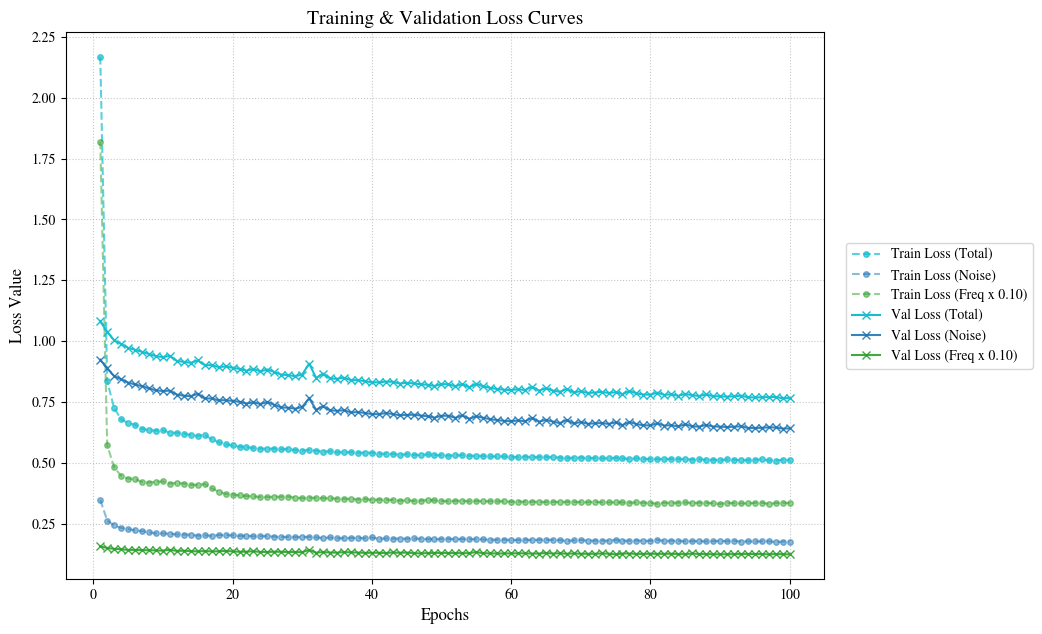

Loss curve saved to ./results/loss_curve.png


In [22]:
def plot_loss(history, save_path, lambda_freq_for_label):

    print("Plotting loss curves...")
    epochs = range(1, len(history['train_loss']) + 1)
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))

    ax.plot(epochs, history['train_loss'], 'o--', color='tab:cyan', label='Train Loss (Total)', alpha=0.7, markersize=4)
    ax.plot(epochs, history['train_noise'], 'o--', color='tab:blue', label='Train Loss (Noise)', alpha=0.5, markersize=4)

    if lambda_freq_for_label > 0:
        scaled_train_freq = [l * lambda_freq_for_label for l in history['train_freq']]
        ax.plot(epochs, scaled_train_freq, 'o--', color='tab:green', label=f'Train Loss (Freq x {lambda_freq_for_label:.2f})', alpha=0.5, markersize=4)

    ax.plot(epochs, history['val_loss'], 'x-', color='tab:cyan', label='Val Loss (Total)', alpha=1.0, markersize=6)
    ax.plot(epochs, history['val_noise'], 'x-', color='tab:blue', label='Val Loss (Noise)', alpha=0.9, markersize=6)

    if lambda_freq_for_label > 0:
        scaled_val_freq = [l * lambda_freq_for_label for l in history['val_freq']]
        ax.plot(epochs, scaled_val_freq, 'x-', color='tab:green', label=f'Val Loss (Freq x {lambda_freq_for_label:.2f})', alpha=0.9, markersize=6)

    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Loss Value', fontsize=12)
    ax.set_title('Training & Validation Loss Curves', fontsize=14)
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10)

    fig.tight_layout(rect=[0, 0.03, 0.88, 0.95])

    fig.savefig(save_path, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print(f"Loss curve saved to {save_path}")

plot_loss(history=training_history,
  save_path=os.path.join("./results", "loss_curve.png"),
  lambda_freq_for_label=0.1
)

In [23]:
def tensor_to_display(img_tensor):
    img_tensor = img_tensor.detach().cpu().clamp(-1, 1)
    return (img_tensor + 1.0) / 2.0

@torch.no_grad() # disable gradient calculations during inference
def generative_denoising(y_noisy, score_model, sde, sigma_n, n_steps, eps=1e-5, return_intermediate=False):
    """
    reverse-time SDE solver
    denoising y = x0 + N(0, sigma_n^2))
    It starts from pure noise and iteratively refines it, conditioned on the
    provided noisy image `y_noisy`, to estimate the original clean image `x0`

    y_noisy (torch.Tensor): The input noisy image(s) to be denoised.
                            Shape: [B, C, H, W]
    score_model (nn.Module): The pre-trained noise prediction model
                              maps (xt, t) -> z_pred.
    sde (VPSDE): forward VP-SDE process and parameters (alpha_t, sigma_t).
    sigma_n (float): The standard deviation of the noise assumed to be present in `y_noisy`.
    n_steps (int): The number of discretization steps for the reverse SDE solver.
    eps (float): The minimum time step to reach (close to 0)
    return_intermediate (bool): If True, stores and returns intermediate frames
                                for visualization.

    output: Returns the final denoised image estimate x0_pred.
            Shape: [B, C, H, W].
    """
    score_model.eval()

    # start from pure Gaussian noise (sample from prior p(x_T))
    # x represents the current state xt in the reverse process
    x = torch.randn_like(y_noisy) # Shape: [B, C, H, W]

    # discrete time steps for the reverse process, from T (1.0) down to eps
    time_steps = torch.linspace(1.0, eps, n_steps + 1, device=y_noisy.device)

    intermediate_frames = []
    if return_intermediate:
        initial_noise_grid = make_grid(tensor_to_display(x.clamp(-1.0, 1.0)), nrow=int(math.sqrt(y_noisy.size(0))))
        intermediate_frames.append((initial_noise_grid.permute(1, 2, 0).numpy() * 255).astype(np.uint8))

    pbar_denoise = tqdm(range(n_steps), desc="Generative Denoising Steps", leave=False, disable=return_intermediate)

    # --- reverse time iteration (from t=1 down to t=0) ---
    for i in pbar_denoise:
        # current time t_curr (t_{k+1}) and next time t_next (t_k)
        t_curr, t_next = time_steps[i], time_steps[i+1]
        t_batch = torch.full((y_noisy.size(0),), t_curr.item(), device=y_noisy.device, dtype=torch.float32)

        # --- conditioning step ---
        # based on the posterior mean update using Tweedie's formula for Gaussian noise.
        # sigma_t = sqrt(1 - alpha_bar_t) from the SDE schedule
        sigma_t = sde.sigma(t_batch).view(-1, 1, 1, 1)
        sigma2_t = sigma_t ** 2

        # lambda_t controls the mixing strength based on relative noise levels
        lambda_t = sigma2_t / (sigma2_t + sigma_n**2) # sigma_n is the noise in y_noisy

        # update x by mixing current state with y_noisy
        x = (1 - lambda_t) * x + lambda_t * y_noisy


        # --- denoising Step (estimate score + removie-noise) ---
        # predict noise using the score model
        # z_pred corresponds to -sigma_t * score_estimate
        predicted_noise = score_model(x, t_batch) # Shape: [B, C, H, W]

        # estimate clean image x0 based on the current state x and predicted noise
        # rearranged forward SDE formula: x0 = (xt - sigma_t*z) / alpha_t
        alpha_t = sde.alpha(t_batch).view(-1, 1, 1, 1) # alpha_t = sqrt(alpha_bar_t)

        x0_pred = (x - sigma_t * predicted_noise) / alpha_t
        x0_pred.clamp_(-1.0, 1.0)

        # sample the state at the previous time step (t_next)
        # uses the estimated x0_pred to calculate the mean and std of the
        # reverse transition p(x_t_next | x_t_curr) and samples from it.
        # get mean and std for q(x_t_next | x0_pred)
        mean_next, std_next = sde.marginal_prob(x0_pred, torch.full_like(t_batch, t_next.item()))

        # sample Gaussian noise for the stochastic step
        z = torch.randn_like(x) if i < n_steps - 1 else 0 # No noise added at the very last step

        # update x to the sampled state for the previous time step
        x = mean_next + std_next.view(-1, 1, 1, 1) * z


        if return_intermediate:
            current_frame_batch = x.clamp(-1.0, 1.0) if i < n_steps - 1 else x0_pred.clamp(-1.0, 1.0)
            grid = make_grid(tensor_to_display(current_frame_batch), nrow=int(math.sqrt(y_noisy.size(0))))
            intermediate_frames.append((grid.permute(1, 2, 0).numpy() * 255).astype(np.uint8))

    # x0_pred calculated in the last step
    final_image = x0_pred.clamp(-1.0, 1.0)

    return (final_image, intermediate_frames) if return_intermediate else final_image

In [24]:
MODEL_SAVE_PATH = "./models/model.pth"
RESULT_DIR = "./results"
os.makedirs(RESULT_DIR, exist_ok=True)
N_VIZ_IMAGES = 16
NOISE_LEVEL_VIZ = 0.3
N_STEPS_VIZ = 1000
N_STEPS_GIF = 500
N_GIF_FRAMES = 100
GIF_DURATION = 100

checkpoint = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint['model'])
model.eval()

Unet(
  (time_mlp): Sequential(
    (0): Linear(in_features=1, out_features=384, bias=True)
    (1): SiLU()
    (2): Linear(in_features=384, out_features=96, bias=True)
  )
  (conv_in): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down1): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (down2): Conv2d(192, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (mid1): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mid_attn): SelfAttention(
    (norm): GroupNorm(12, 384, eps=1e-05, affine=True)
    (to_qkv): Conv2d(384, 1152, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (to_out): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
  )
  (mid_t): Linear(in_features=96, out_features=384, bias=True)
  (mid2): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up1): ConvTranspose2d(384, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (skip_conv1): Conv2d(192, 192, kernel_size=(1, 1), s

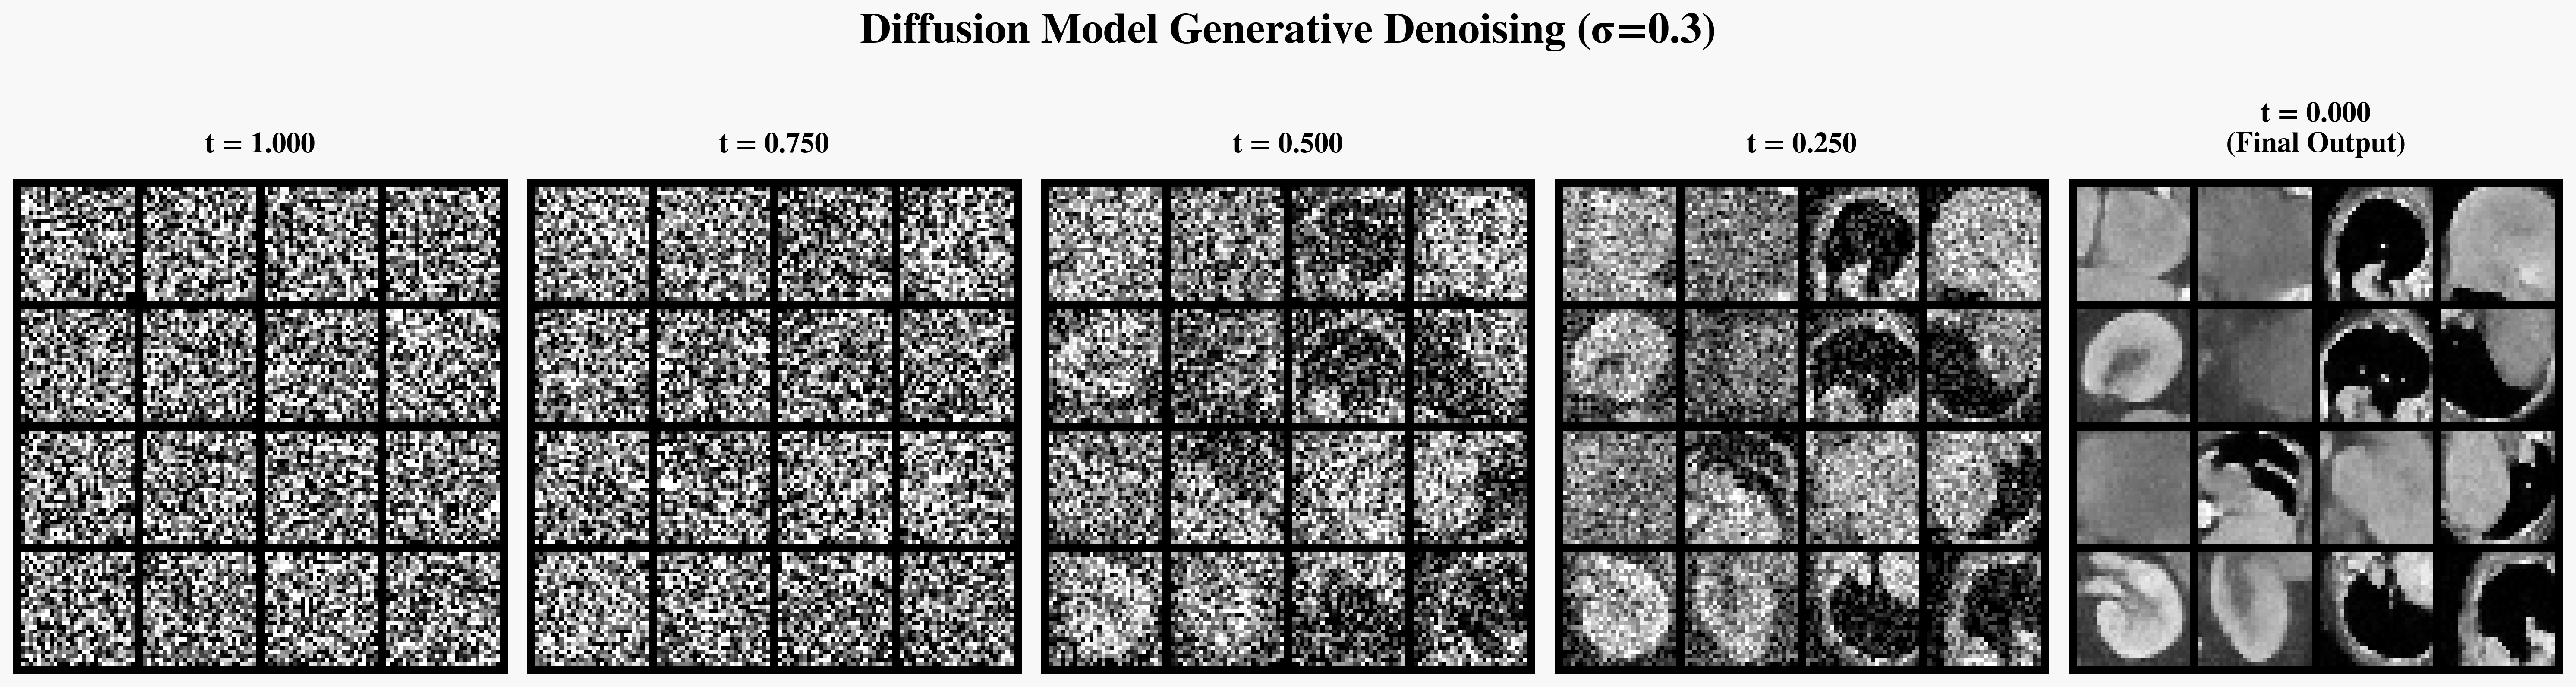

In [25]:
final_denoised_img, all_frames = generative_denoising(
    y_noisy=viz_batch_noisy,
    score_model=model,
    sde=sde,
    sigma_n=NOISE_LEVEL_VIZ,
    n_steps=N_STEPS_VIZ,
    return_intermediate=True
)

if all_frames and len(all_frames) > 1:
    gif_indices = np.linspace(0, len(all_frames) - 1, N_GIF_FRAMES, dtype=int)
    gif_frames_to_save = [all_frames[i] for i in gif_indices]

    gif_path = os.path.join(RESULT_DIR, "reverse_process_denoising.gif")
    imageio.mimsave(
        gif_path,
        gif_frames_to_save,
        duration=GIF_DURATION,
        loop=0,
        quality=95
    )

    frame_indices_to_save = [0, N_STEPS_VIZ // 4, N_STEPS_VIZ // 2, 3 * N_STEPS_VIZ // 4, N_STEPS_VIZ - 1]
    for i, idx in enumerate(frame_indices_to_save):
        if 0 <= idx < len(all_frames):
            if idx == N_STEPS_VIZ - 1:
                t_value = 0.0
            else:
                t_value = 1.0 - (idx / (N_STEPS_VIZ - 1))

            frame_path = os.path.join(RESULT_DIR, f"reverse_frame_t{t_value:.3f}.png")

            plt.figure(figsize=(12, 12), dpi=300)
            plt.imshow(all_frames[idx])
            plt.axis('off')
            plt.title(f"t = {t_value:.3f}", fontsize=20, fontweight='bold')
            plt.tight_layout(pad=0)
            plt.savefig(frame_path, bbox_inches='tight', pad_inches=0.1, dpi=300)
            plt.close()


def plot_reverse_snapshots(intermediate_frames, total_steps, save_path, title="Reverse Process"):
    if not intermediate_frames or len(intermediate_frames) < 1:
        return

    num_frames = len(intermediate_frames)
    indices = [0]

    for i in range(1, 4):
        idx = min(int((i * num_frames) / 4), num_frames - 1)
        indices.append(idx)

    indices.append(num_frames - 1)

    times = []
    for i, idx in enumerate(indices):
        if idx == num_frames - 1:
            times.append(0.0)
        else:
            times.append(1.0 - (idx / (num_frames - 1)))

    fig, axes = plt.subplots(1, len(indices), figsize=(20, 6), dpi=300)

    fig.suptitle(title, fontsize=24, fontweight='bold', y=0.98)
    plt.subplots_adjust(top=0.85, wspace=0.1)

    fig.patch.set_facecolor('#f8f8f8')

    for i, (idx, t_val) in enumerate(zip(indices, times)):
        axes[i].imshow(intermediate_frames[idx], cmap='gray' if intermediate_frames[idx].ndim == 2 else None)
        if i == 0:
            label = f"t = {t_val:.3f}"
        elif i == len(indices) - 1:
            label = f"t = 0.000\n(Final Output)"
        else:
            label = f"t = {t_val:.3f}"

        axes[i].set_title(label, fontsize=16, fontweight='bold', pad=15)
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()
    plt.close(fig)

if 'all_frames' in locals() and all_frames:
    plot_reverse_snapshots(
        intermediate_frames=all_frames,
        total_steps=N_STEPS_VIZ,
        save_path=os.path.join(RESULT_DIR, "reverse_process_snapshots.png"),
        title=f"Diffusion Model Generative Denoising (σ={NOISE_LEVEL_VIZ})"
    )

In [26]:
denoised_batch_viz = generative_denoising(
    y_noisy=viz_batch_noisy, score_model=model, sde=sde,
    sigma_n=NOISE_LEVEL_VIZ, n_steps=N_STEPS_VIZ, return_intermediate=False
)

psnr_metric = PeakSignalNoiseRatio(data_range=2.0).to(DEVICE)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=2.0).to(DEVICE)

def calculate_metrics(pred, target):
    pred = pred.clamp(-1.0, 1.0); target = target.clamp(-1.0, 1.0)
    psnr_val = psnr_metric(pred.to(DEVICE), target.to(DEVICE)).item()
    ssim_val = ssim_metric(pred.to(DEVICE), target.to(DEVICE)).item()
    return psnr_val, ssim_val

psnr_noisy, ssim_noisy = calculate_metrics(viz_batch_noisy, viz_batch_clean)
psnr_denoised, ssim_denoised = calculate_metrics(denoised_batch_viz, viz_batch_clean)

print("\n--- Results (16 images) ---")
print(f"Input Noise Level (sigma_n): {NOISE_LEVEL_VIZ:.2f}")
print(f"Denoising Steps: {N_STEPS_VIZ}")
print(f"Noisy vs. Clean  : PSNR {psnr_noisy:.2f} dB | SSIM {ssim_noisy:.4f}")
print(f"Denoised vs. Clean: PSNR {psnr_denoised:.2f} dB | SSIM {ssim_denoised:.4f}")
print(f"Improvement       : ΔPSNR {psnr_denoised - psnr_noisy:+.2f} dB | ΔSSIM {ssim_denoised - ssim_noisy:+.4f}")
print("-" * 40)


--- Results (16 images) ---
Input Noise Level (sigma_n): 0.30
Denoising Steps: 1000
Noisy vs. Clean  : PSNR 17.21 dB | SSIM 0.5372
Denoised vs. Clean: PSNR 19.66 dB | SSIM 0.5364
Improvement       : ΔPSNR +2.44 dB | ΔSSIM -0.0008
----------------------------------------


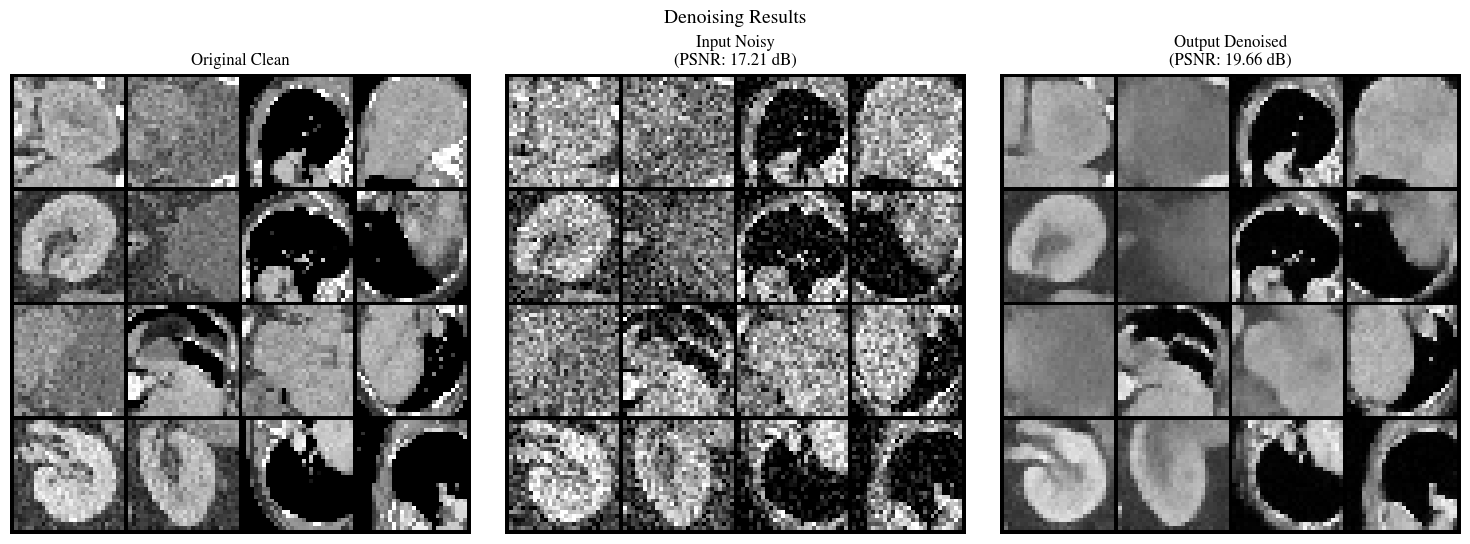

In [27]:
save_path = os.path.join(RESULT_DIR, "final_comparison.png")
fig, axes = plt.subplots(1, 3, figsize=(15, 5.5))
grid_args = {"nrow": int(math.sqrt(N_VIZ_IMAGES)), "padding": 1}
clean_grid = make_grid(tensor_to_display(viz_batch_clean), **grid_args)
noisy_grid = make_grid(tensor_to_display(viz_batch_noisy), **grid_args)
denoised_grid = make_grid(tensor_to_display(denoised_batch_viz), **grid_args)

plots = [clean_grid, noisy_grid, denoised_grid]
titles = ["Original Clean", f"Input Noisy\n(PSNR: {psnr_noisy:.2f} dB)", f"Output Denoised\n(PSNR: {psnr_denoised:.2f} dB)"]

for ax, img_grid, title in zip(axes, plots, titles):
    ax.imshow(img_grid.permute(1, 2, 0))
    ax.set_title(title); ax.axis('off')

fig.suptitle("Denoising Results", fontsize=14); fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_path); plt.show(); plt.close(fig)